# Matrix Profile for Identifying Material Boundaries

In [27]:
import dataparser as dp
import matrixprofile as mp
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

In [21]:
# Set your data path here
path = "8B life test/E00401009F45AF14_18080018_ST_2109_27.xls"

## Introduction
Go [here](https://towardsdatascience.com/how-to-painlessly-analyze-your-time-series-f52dab7ea80d) for a good explanation of the subject

Matrix Profile is a suite of tools for looking at patterns and anomalys (discords) in time series data. It takes a snippet of data and slides it across the rest of the signal and calculates how similar it is to each section of the same length.

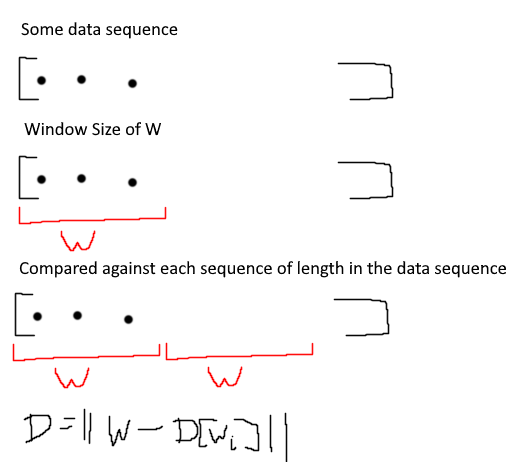

So for a fixed window size, we can plot the distances across a signal

![plot.png](https://miro.medium.com/v2/resize:fit:720/0*CXUKGdqGbWDJNwIv)

c:\Users\uos\AppData\Local\Programs\Python\Python310\lib\site-packages\matrixprofile\visualize.py:433: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


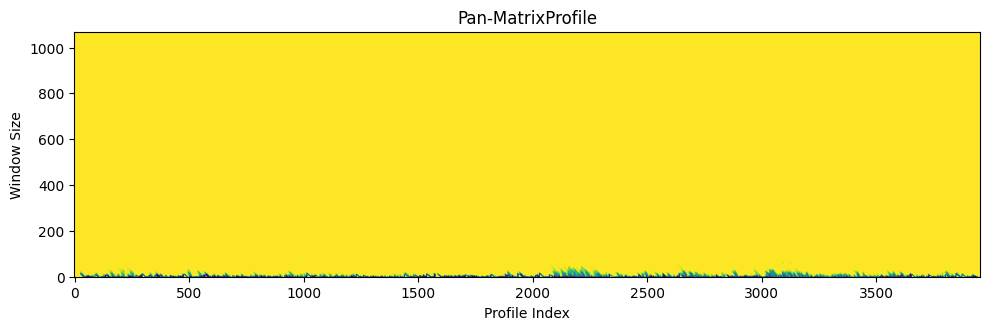

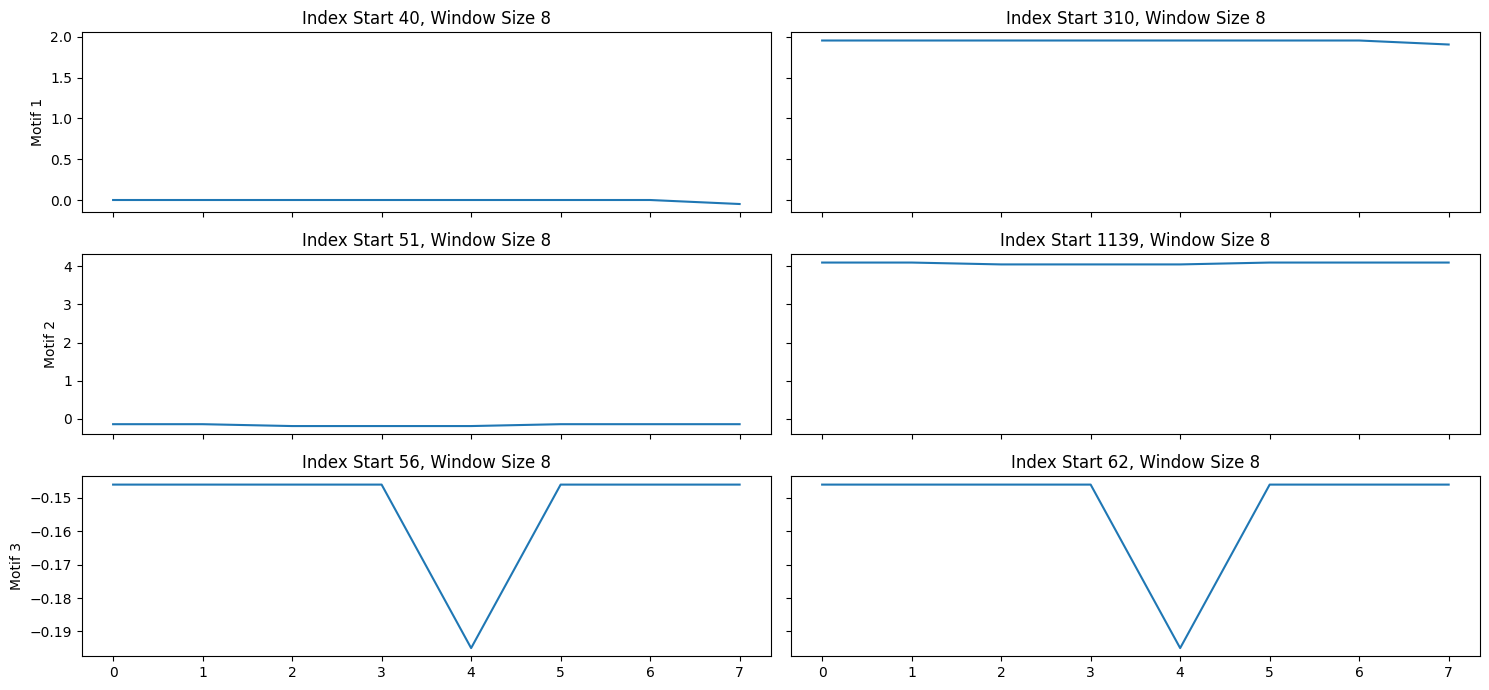

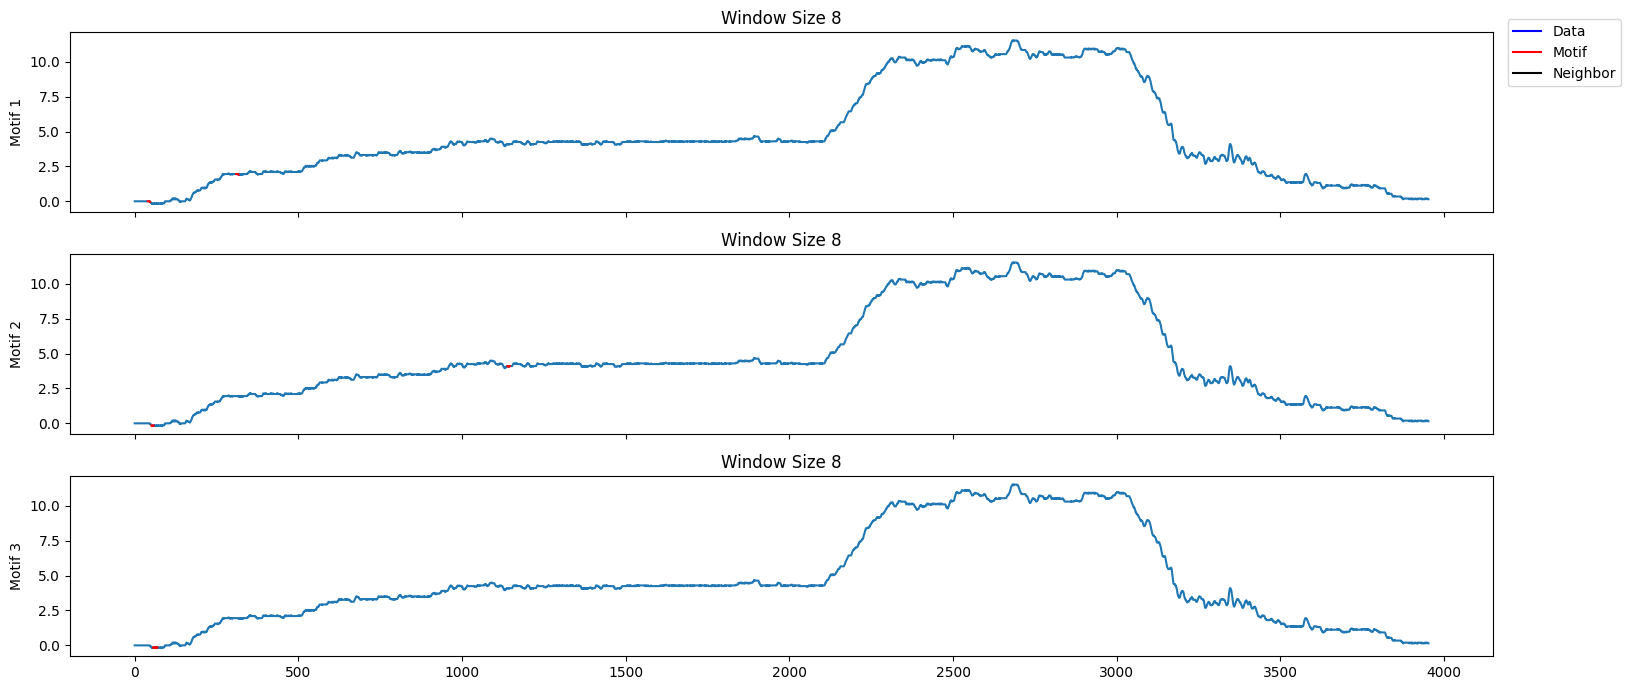

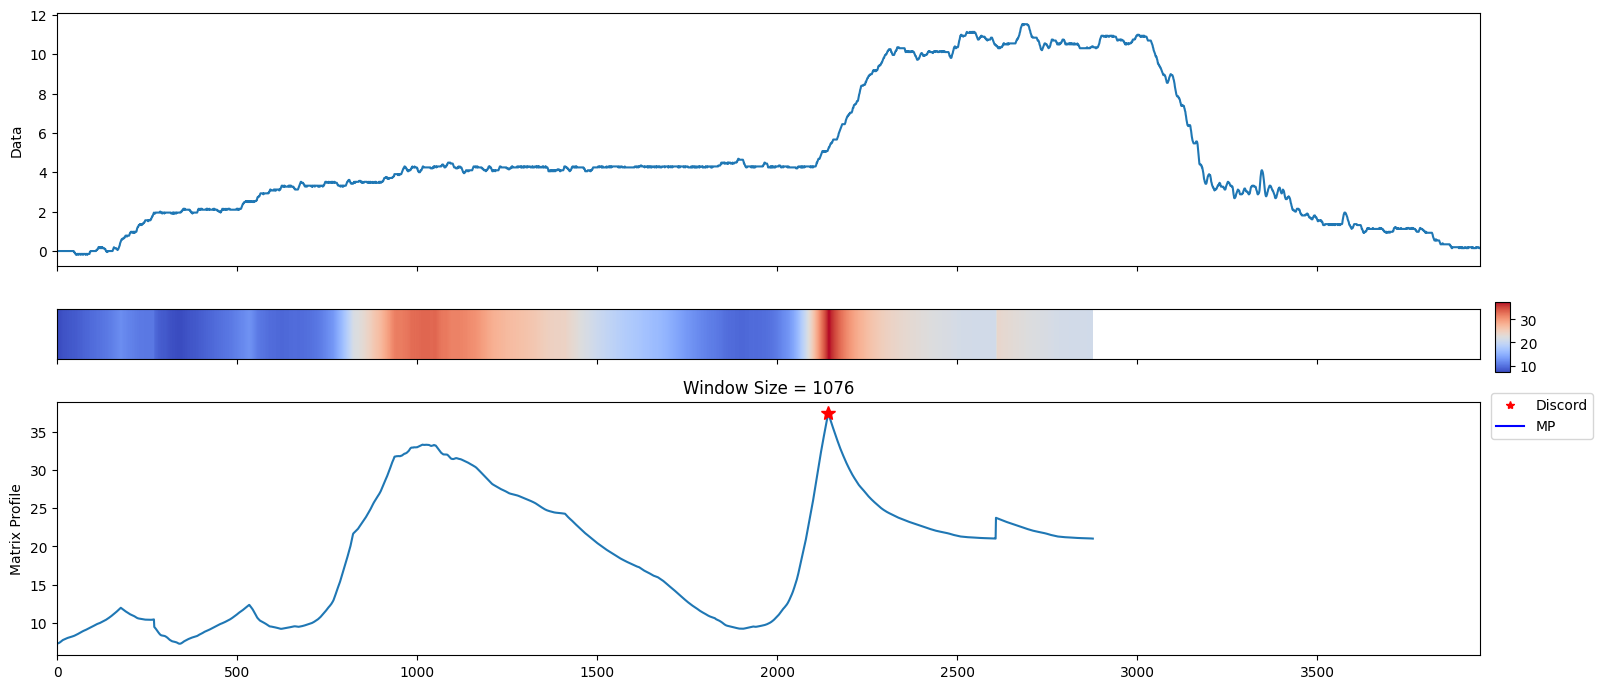

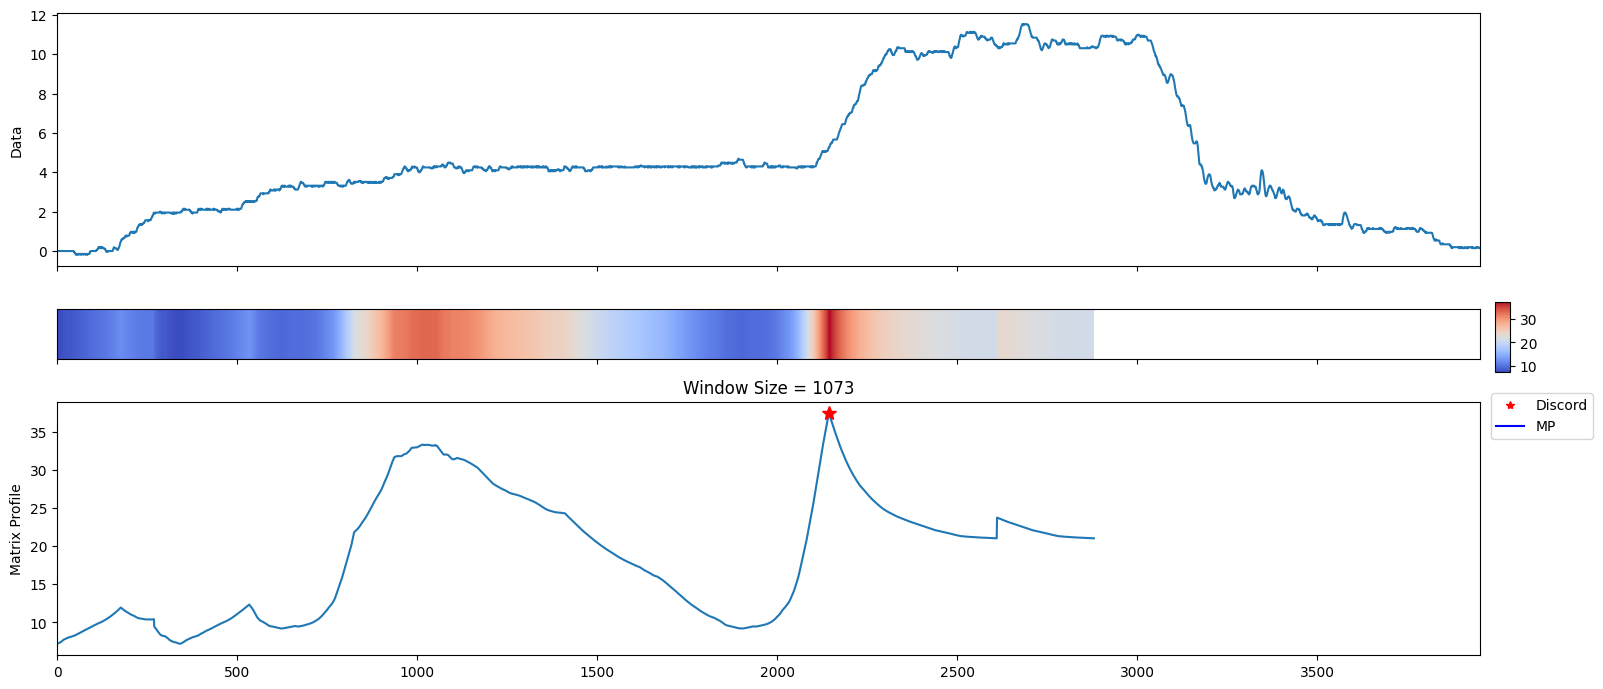

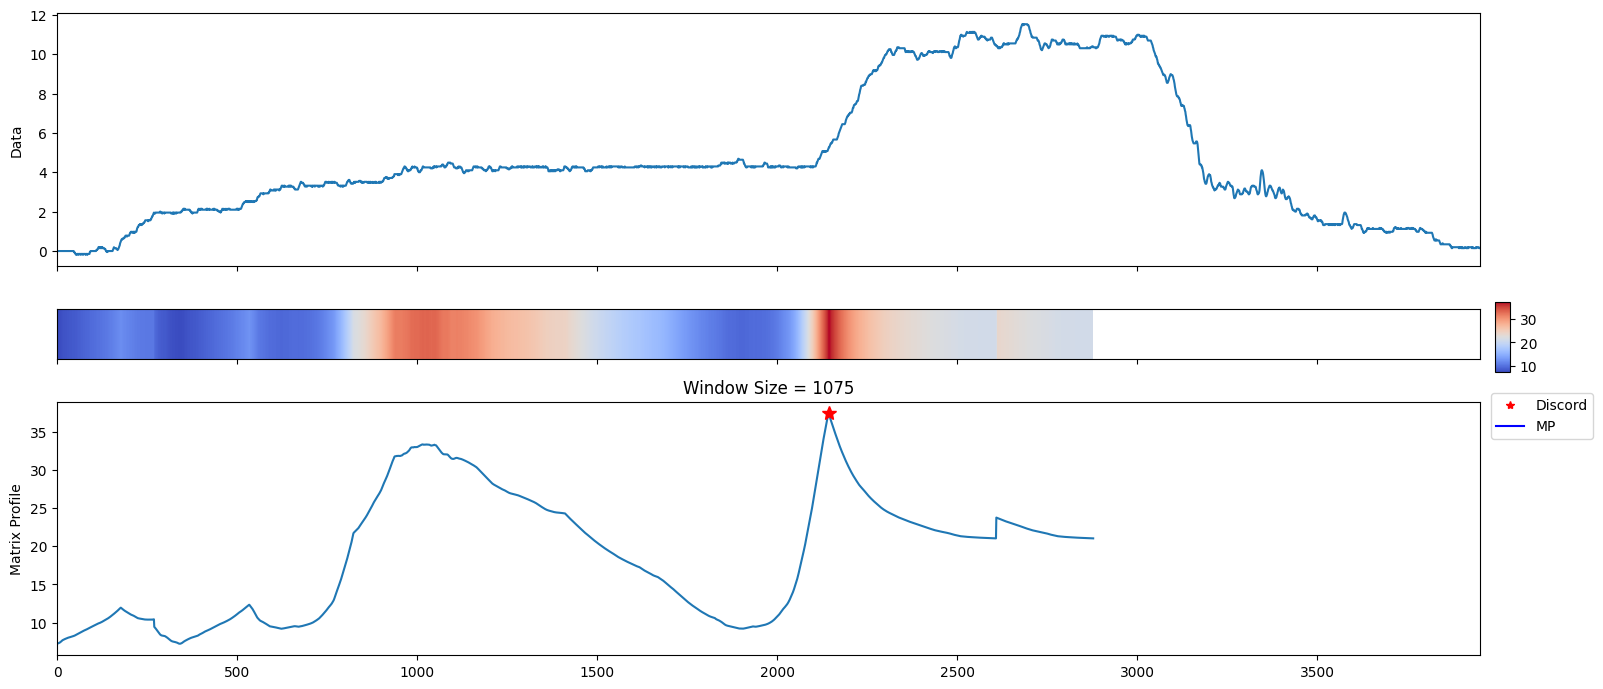

In [22]:
data = dp.loadSetitecXls(path,"auto_data")
profile,figures = mp.analyze(data["I Torque (A)"].values,n_jobs=6)

As we didn't specify the size of the window, matrixprofile tried a range window sizes via a calculation called Pan-Matrix Profile (PMP). This tries all possible window sizes and plots them in a single matrix. The other plots provide some information of particularly interesting responses when creating the PMP. **The darker the shade, the closer/more similar the window is.**

The 3x2 grid plot is the top three repeating patterns (motifs) and top three anomalies (discords) in the sequence with the title listing their window size and where they occcured. So if the window size is 8, imagine the signal broken up into chunks of 8 and the index referring to which chunk is of interest. The plot afterwards is meant to clearly show where these have occured but can be difficult.

The final three plots show which window sizes created the biggest discord.

The plots show that we seem to get a distinct anomaly for window sizes between 1075 and 1080 so narrowing down the window sizes could be useful.

c:\Users\uos\AppData\Local\Programs\Python\Python310\lib\site-packages\matrixprofile\visualize.py:433: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


3953


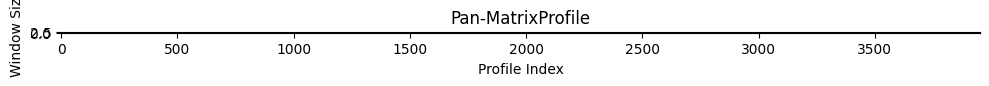

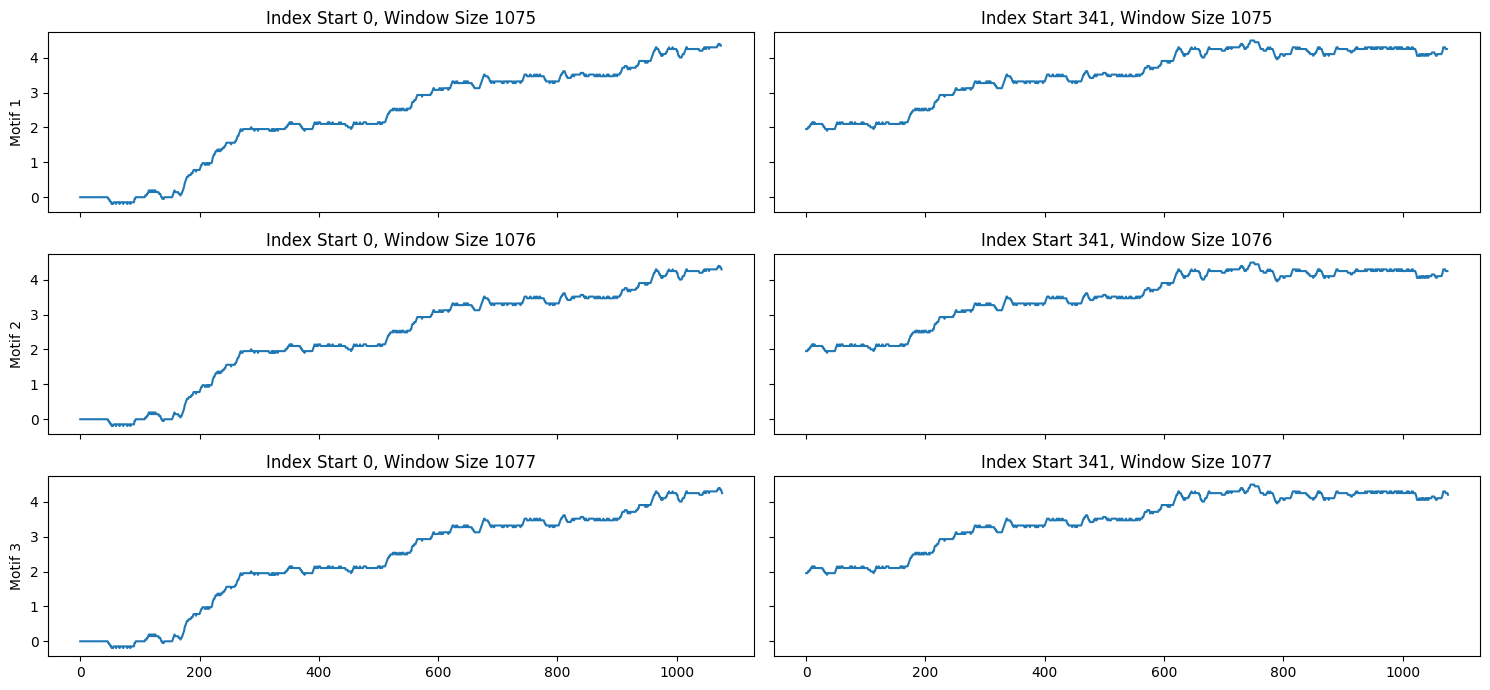

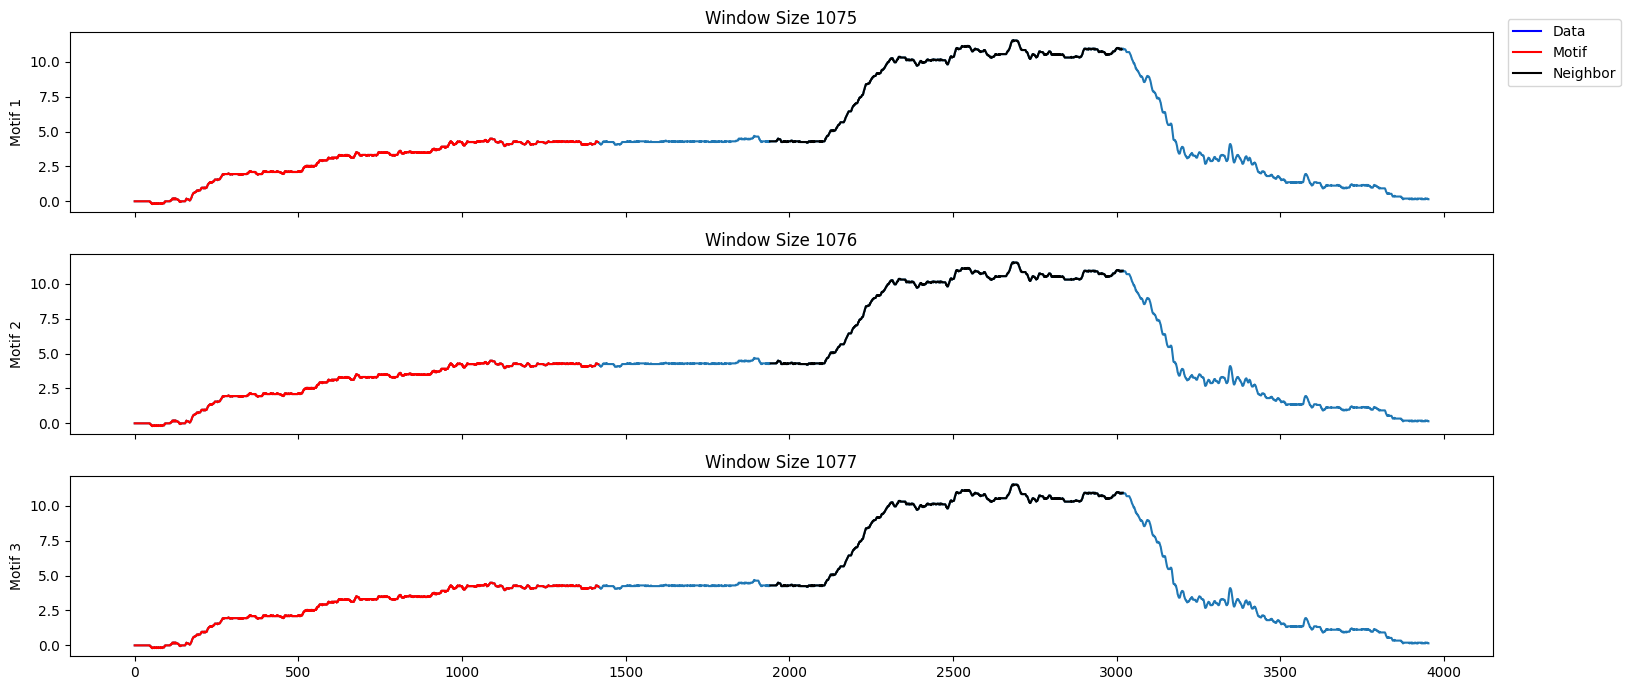

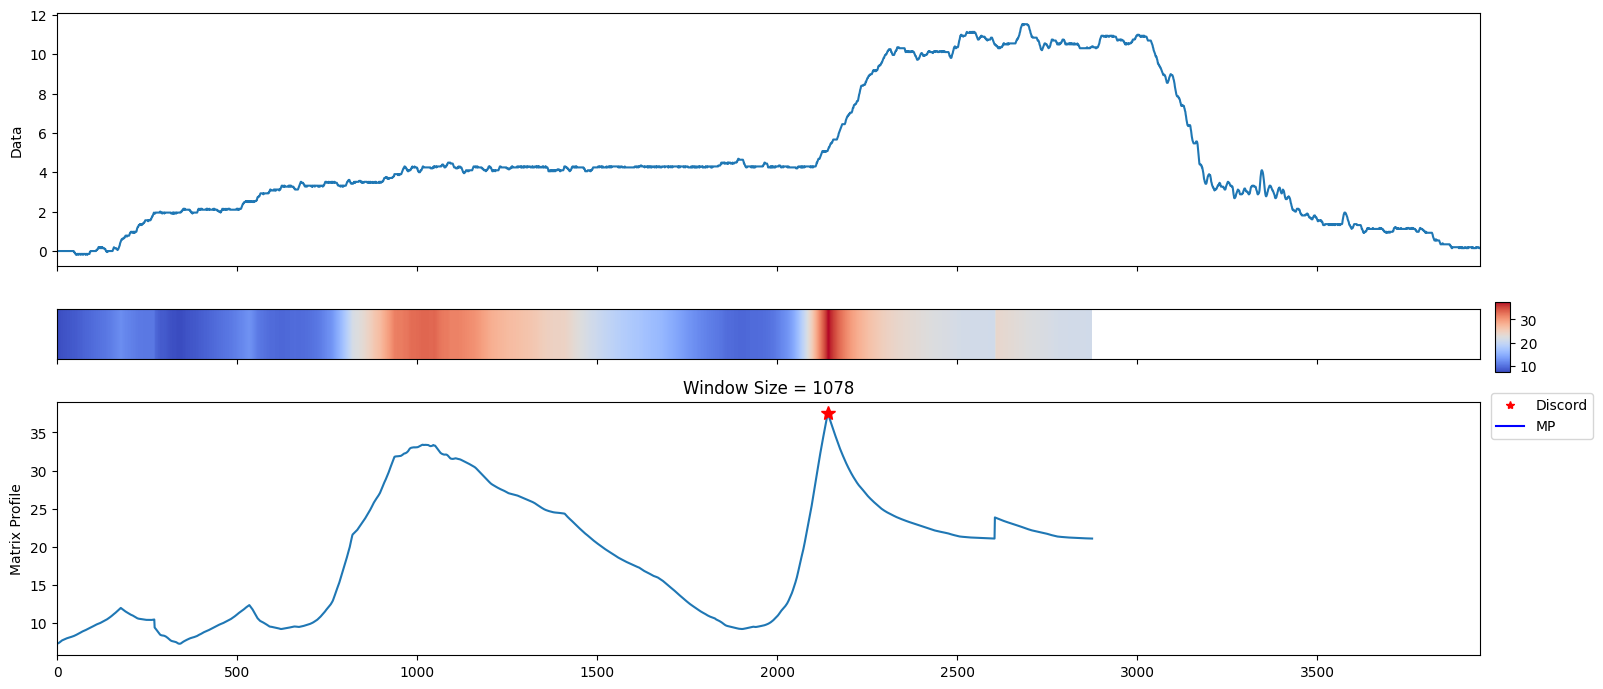

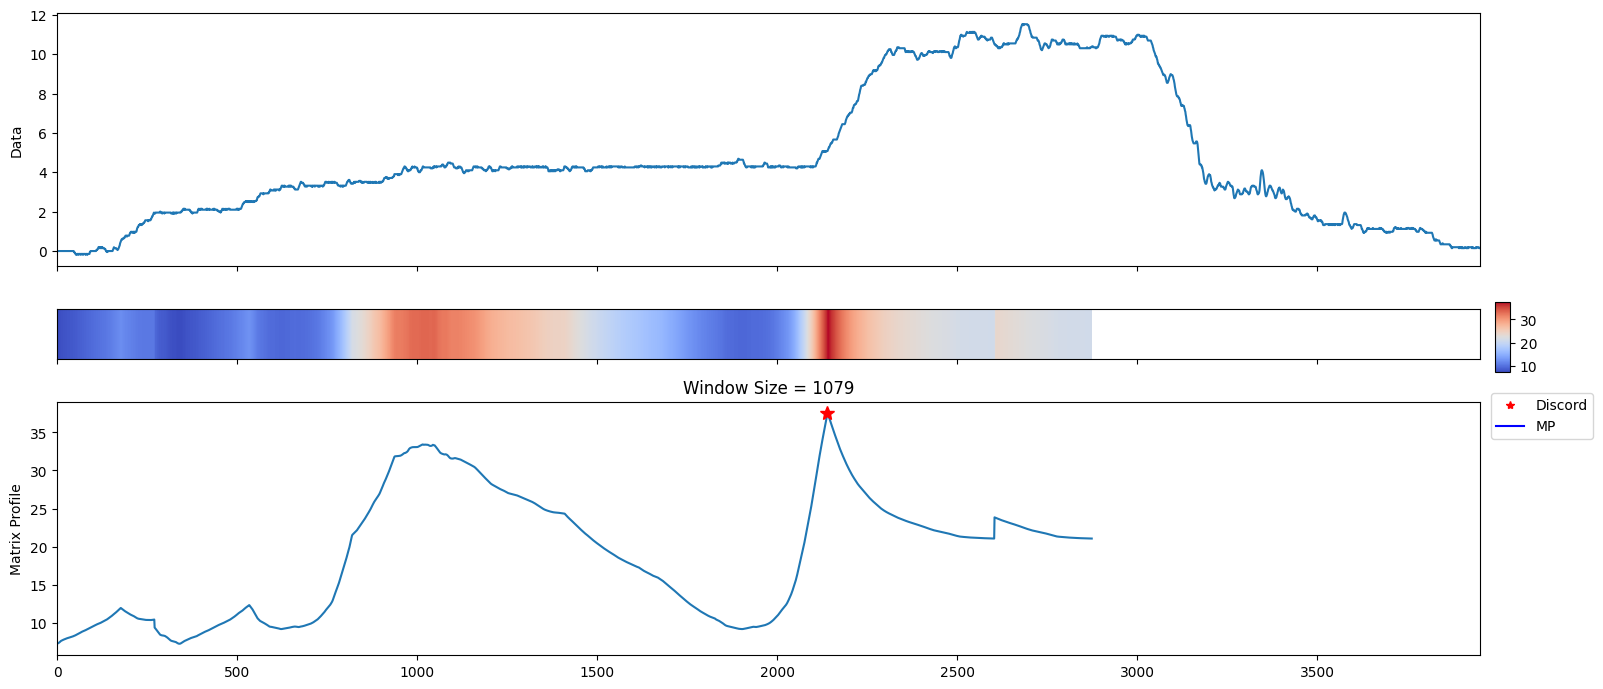

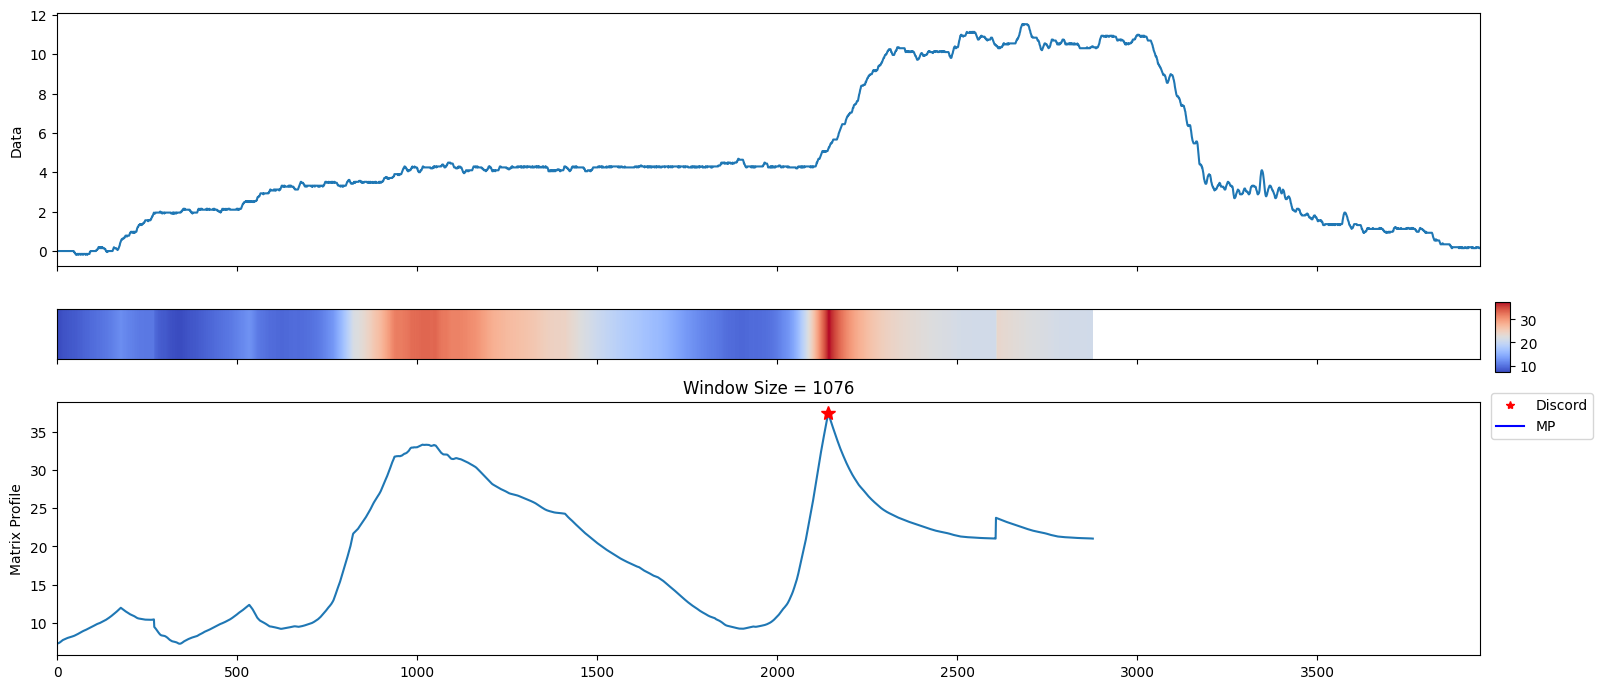

In [49]:
data = dp.loadSetitecXls(path,"auto_data")
profile,figures = mp.analyze(data["I Torque (A)"].values,windows=np.arange(1075,1080,1),n_jobs=6)
print(len(data["I Torque (A)"].values))

The annotated plot with the discord (anomaly) and motif (repeating pattern) shows where it thinks it occurs in the signal. With the widened target window, the current top pattern is the calibration signal. The main anomaly is the first half of the second material.

The following code example is an attempt to find the "true" motif by ignoring a starting portion of the signal. In the previous plots, the motif was the starting portion of the signal is most likely our calibration signal which it is searching for. Given the torque signal is generally non-repeating (for two distinct materials), it's best match will be the signal itself rather than anywhere else.

As an experiment, we're going to ignore the signal to see what else it picks up. The attention vector (AV) is a boolean mask to indicate which values whould be looked at (1) and which should be ignored (0). The cut off is based on the window size (W) for simplicity.

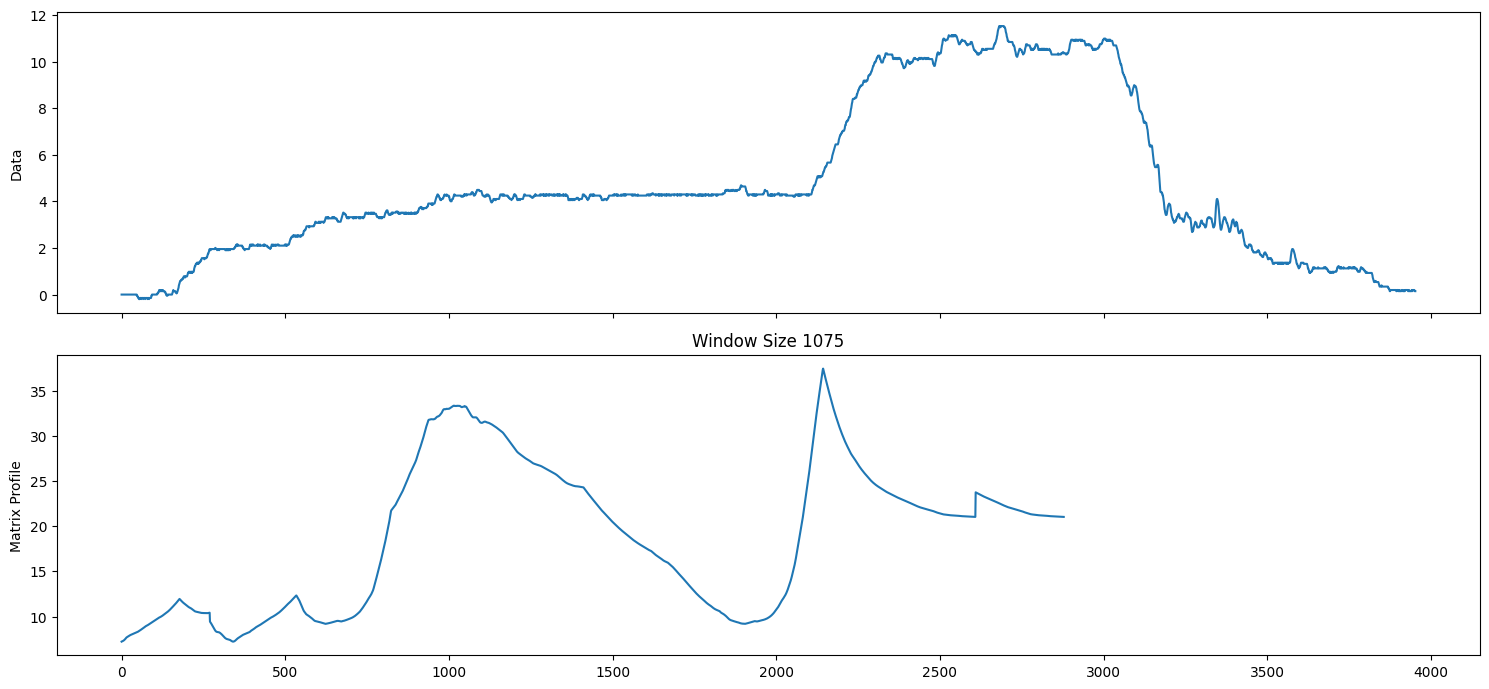

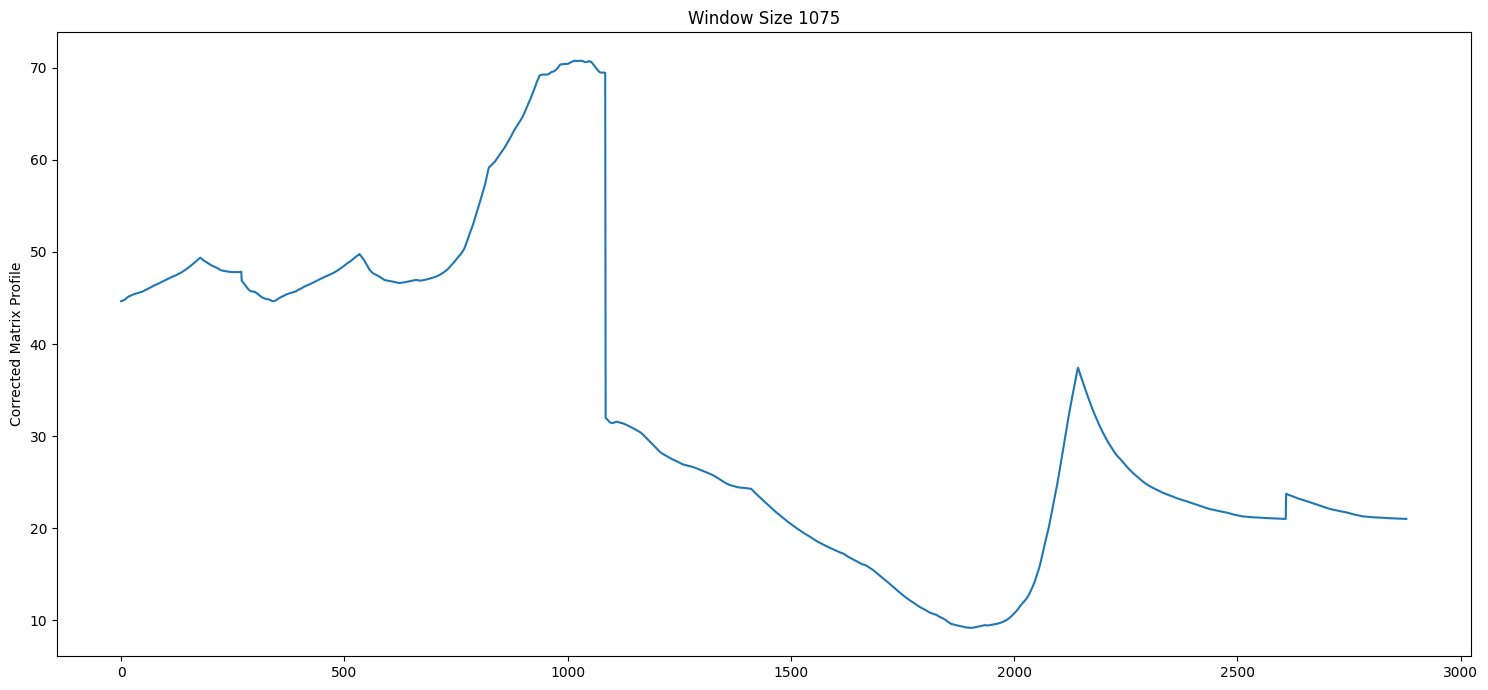

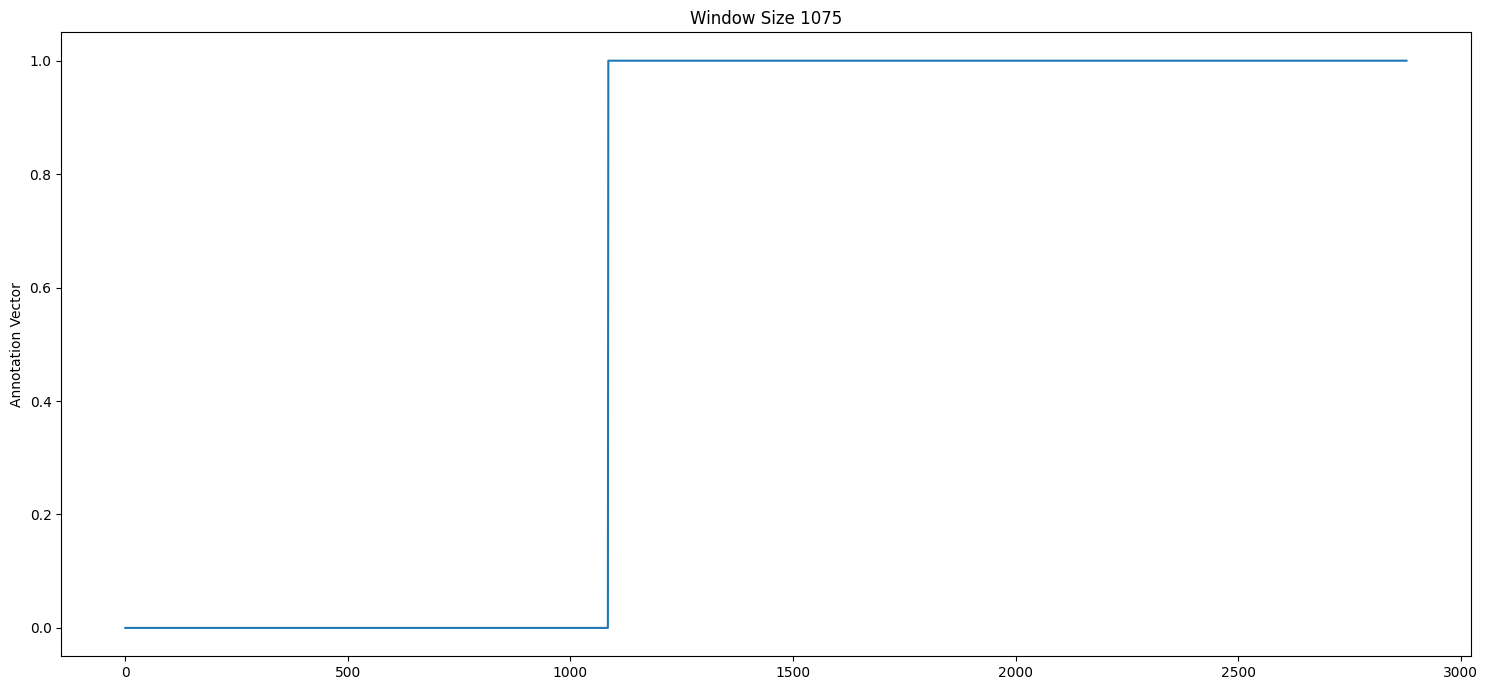

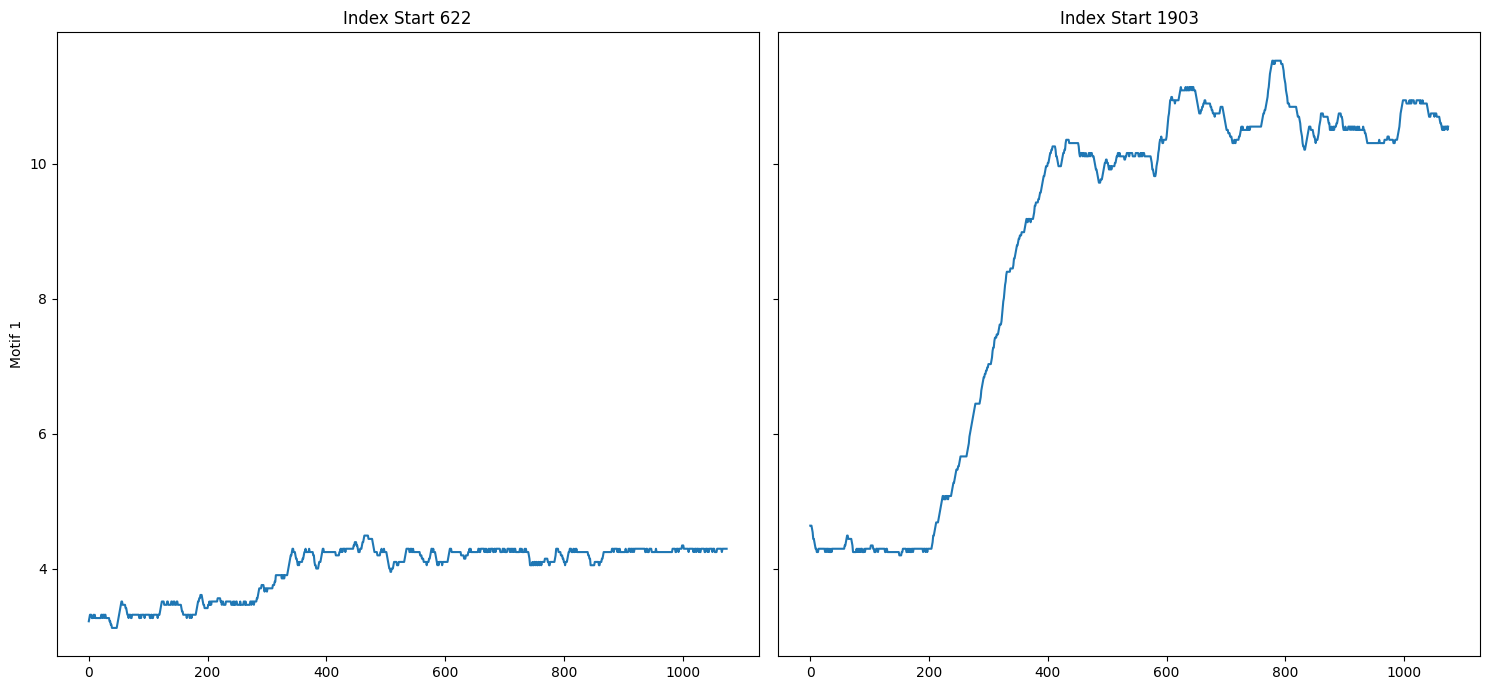

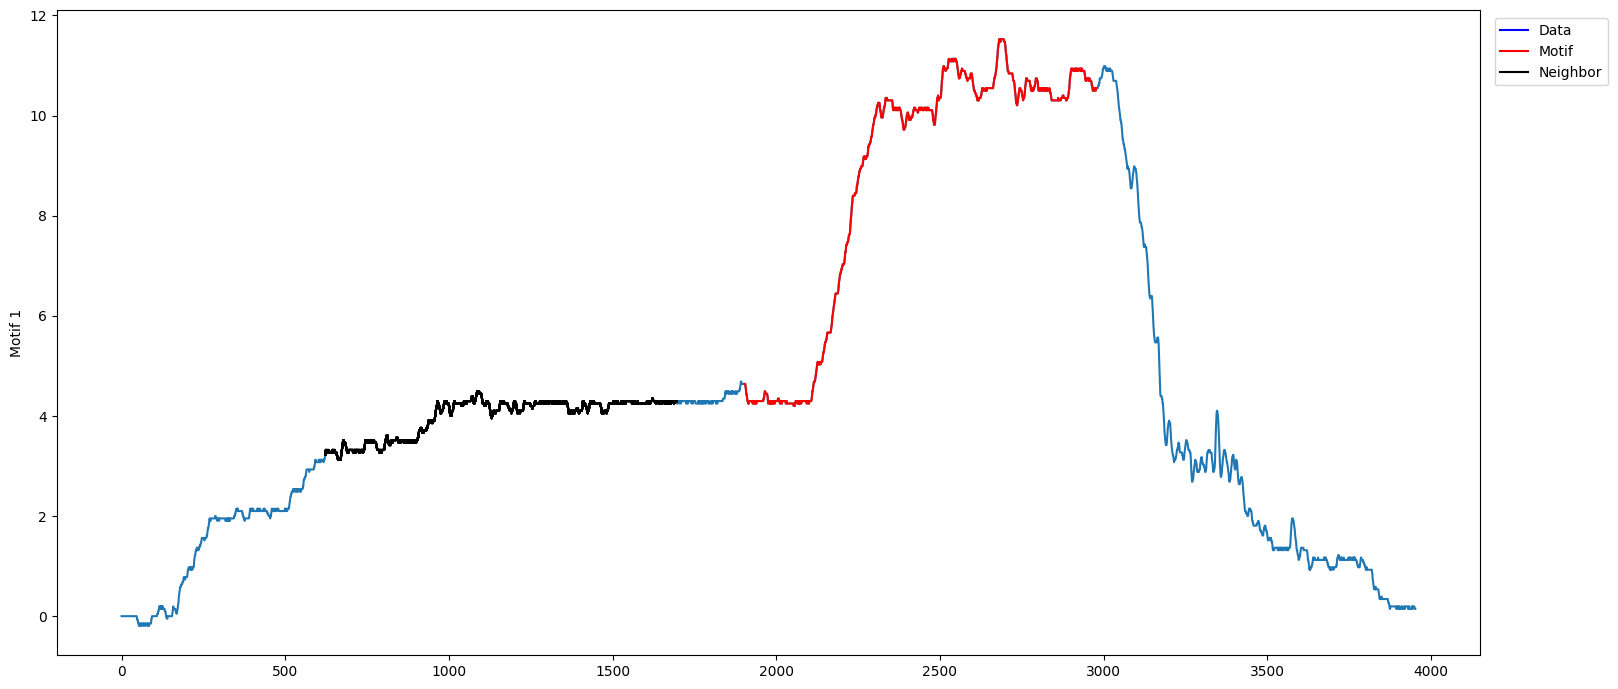

In [56]:
# from https://matrixprofile.docs.matrixprofile.org/examples/ECG_Annotation_Vectors.html
W = 1075
profile = mp.compute(data["I Torque (A)"].values, windows=W)
profile = mp.discover.motifs(profile, k=1)
threshold = W+10
av = np.append(np.zeros(threshold), np.ones(len(profile['mp']) - threshold))
profile = mp.transform.apply_av(profile, "custom", av)
profile = mp.discover.motifs(profile, k=1, use_cmp=True)
figures = mp.visualize(profile)

Curiously the detected Discord appears to be where the material changes from the first material to the second material. This is likely to work when the second material is much harder than the first material. For similar material stacks (CFRP-CFRP) the change might not be as distinct.

For the majority of the data collected, the material config is CFRP-Al which is a soft then hard material so is a decent test case for seeing these changes.

The following code plots the discord locations for each file in a target path. It uses a fixed window size based on the previous results. The result is a scatter plot where the x-axis is the file index and the y-index is the discord locations in the signal. Each file can have more than one discord.

Average Discord location 27.697128295898438, std dev 2.300055503845215


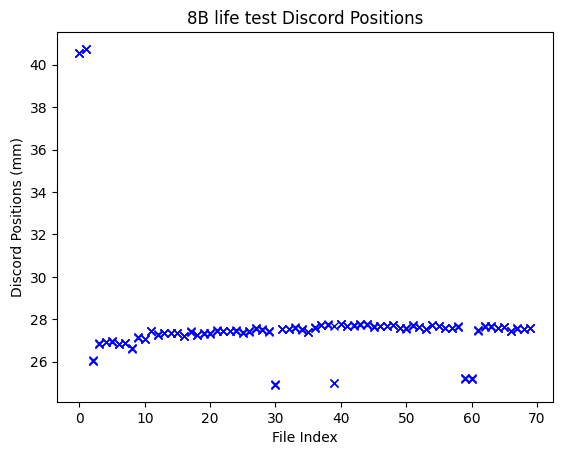

In [47]:
import os
import numpy as np
import seaborn as sns
# Window size
W = 1075
f,ax = plt.subplots()
all_pos = []
L = []
for i,fn in enumerate(sorted(glob("8B life test/*.xls"))):
    data = dp.loadSetitecXls(fn,"auto_data")
    pos = np.abs(data["Position (mm)"].values)
    # find discords in the data
    profile = mp.compute(data['I Torque (A)'].values,W)
    profile = mp.discover.discords(profile)
    pos_discords = [pos[discord] for discord in profile['discords']]
    L.append(len(pos_discords))
    all_pos.extend(pos_discords)
    ax.plot(len(pos_discords)*[i,],pos_discords,'bx')
ax.set(xlabel="File Index",ylabel="Discord Positions (mm)",title=f"{os.path.basename(os.path.dirname(fn))} Discord Positions")
# find average position
mean = np.mean(all_pos)
std = np.std(all_pos)
print(f"Average Discord location {mean}, std dev {std}")
# find those that deviate from the mean
ii = np.where((all_pos<=(2*std+mean))|(all_pos>=(2*std+mean)))[0]


[Text(0.5, 0, 'Position (mm)'),
 Text(0, 0.5, 'Torque (A)'),
 Text(0.5, 1.0, '8B life test\\E00401009F45AF14_18080018_ST_2178_96.xls')]

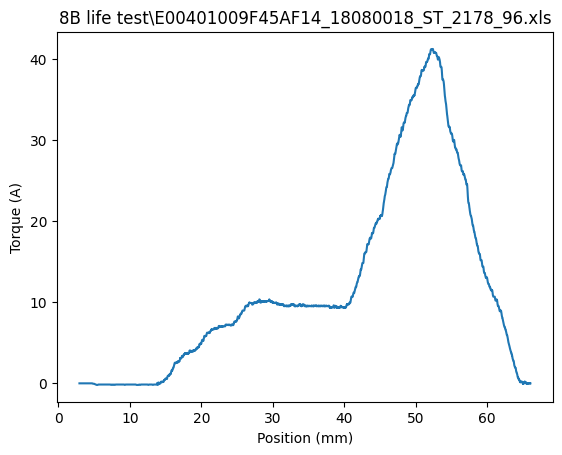

In [60]:
f,ax = plt.subplots()
# using the last file for quick use
data = dp.loadSetitecXls(fn,"auto_data")
pos = np.abs(data["Position (mm)"].values)
ax.plot(pos,data['I Torque (A)'])
ax.set(xlabel="Position (mm)",ylabel="Torque (A)",title=fn)

Each file appears to have several discord locations with the majority being between 26mm and 28mm which is around the middle of the first material.

<Axes: title={'center': '8B life test No. of Discords'}, xlabel='File Index', ylabel='No. of Discords'>

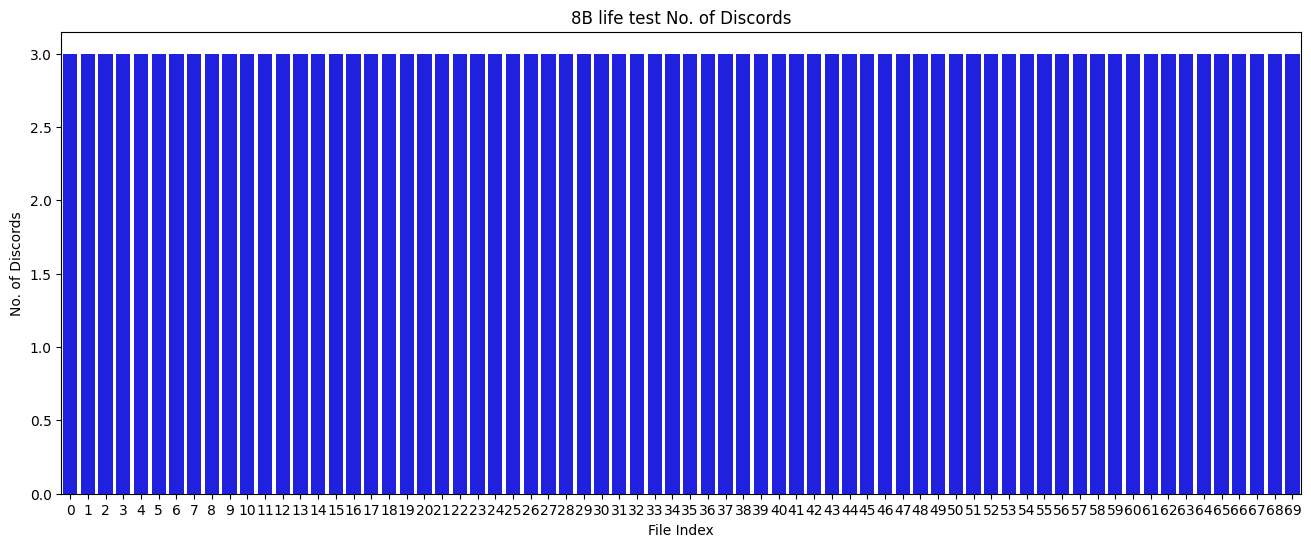

In [59]:
L = np.asarray(L)
fL,axL = plt.subplots(figsize=(16,6))
axL.set(xlabel="File Index",ylabel="No. of Discords",title=f"{os.path.basename(os.path.dirname(fn))} No. of Discords")
sns.barplot(x=list(range(len(L))),y=L,ax=axL, color='b')

## Kernel Matching

As our signal is non-repeating, pattern recognition based on the signal isn't likely to yield a consistent match. Another approach is matching a kernel to find changes in the signal.

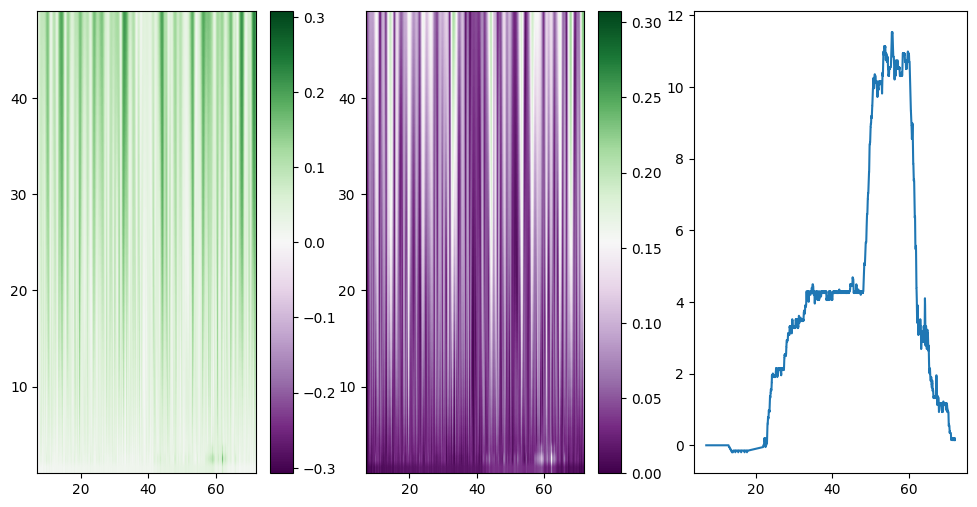

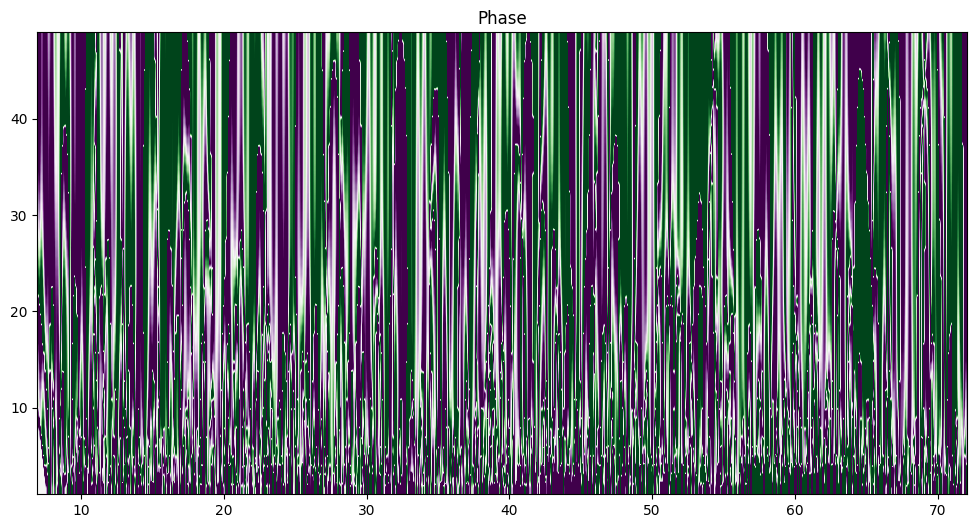

In [83]:
from scipy import signal
data = dp.loadSetitecXls(path,"auto_data")
pos = np.abs(data["Position (mm)"].values) + data["I Torque Empty (A)"].values
sig = data["I Torque (A)"].values
widths = np.arange(1, 50)
cwtmatr = signal.cwt(sig, signal.morlet, widths)
abscwtmatr = np.abs(cwtmatr)
cwtmatr_yflip = np.flipud(abscwtmatr)
f,ax = plt.subplots(ncols=3,figsize=(12,6))
F = ax[0].imshow(cwtmatr_yflip, extent=[pos.min(), pos.max(), 1, widths.max()], cmap='PRGn', aspect='auto',
# stating the min and max of imshow makes the +ve values for obv
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.colorbar(F)
F = ax[1].imshow(cwtmatr_yflip, extent=[pos.min(), pos.max(), 1, widths.max()], cmap='PRGn', aspect='auto',
# stating the min and max of imshow makes the +ve values for obv
           vmax=abs(cwtmatr).max(), vmin=abs(cwtmatr).min())
plt.colorbar(F)
ax[2].plot(pos,sig)

if cwtmatr.dtype == np.complex128:
    fc,axc = plt.subplots(figsize=(12,6))
    cwtmatr_yflip = np.flipud(np.angle(cwtmatr))
    axc.imshow(cwtmatr_yflip, extent=[pos.min(), pos.max(), 1, widths.max()], cmap='PRGn', aspect='auto',
    # stating the min and max of imshow makes the +ve values for obv
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    axc.set_title("Phase")

# Stacking Signals

## Arranging the signal data

Stacked 70 signals from 8B life test\*.xls


[Text(0.5, 0, 'Sample Index'),
 Text(0, 0.5, 'Torque (A)'),
 Text(0.5, 1.0, 'Stacked 8B life test')]

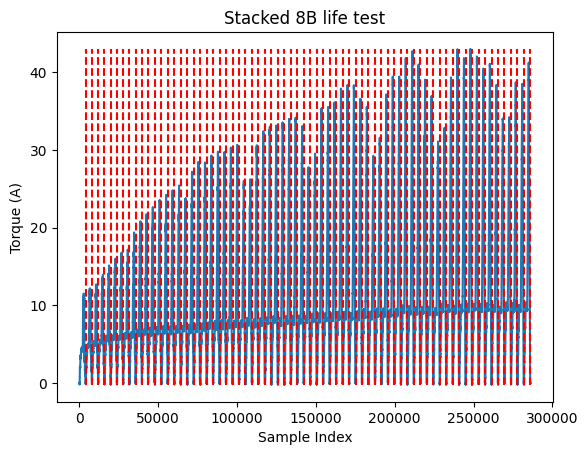

In [1]:
from dataparser import loadSetitecXls
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

DATA_PATH = r"8B life test\*.xls"

def getTorque(path):
    data = loadSetitecXls(path,'auto_data')
    tq = data['I Torque (A)'].values.flatten()
    return tq
stack = list(map(getTorque,glob(DATA_PATH)))
NF = len(stack)
maxtq = max([max(tq) for tq in stack])
mintq = min([min(tq) for tq in stack])
L = np.cumsum([len(tq) for tq in stack])
print(f"Stacked {len(stack)} signals from {DATA_PATH}")
stack_cat = np.concatenate(stack)
f,ax = plt.subplots()
ax.plot(stack_cat)
ax.vlines(L,mintq,maxtq,'r',linestyles='dashed')
ax.set(xlabel="Sample Index",ylabel="Torque (A)",title=f"Stacked {os.path.dirname(DATA_PATH)}")

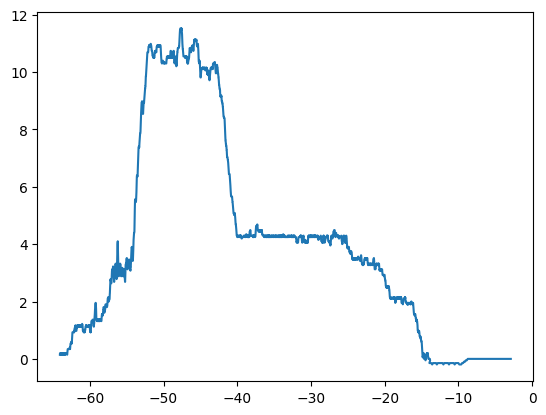

In [8]:
def getPos(path):
    data = loadSetitecXls(path,'auto_data')
    pos = data['Position (mm)'].values.flatten()
    return pos
stack_pos = list(map(getPos,glob(DATA_PATH)))
plt.plot(stack_pos[0],stack[0])

## Grid search for specific breakpoint

In [4]:
import matrixprofile as mp
from multiprocessing import Pool
import numpy as np
# parameters for window size
WIN_MIN = 300
WIN_MAX = 1000
WIN_STEP = 10
WINS = np.arange(WIN_MIN,WIN_MAX,WIN_STEP)
# target position to search for
TARGET_POS = -40.0
# load position data for each
def getPos(path):
    data = loadSetitecXls(path,'auto_data')
    pos = data['Position (mm)'].values.flatten()
    return pos
stack_pos = tuple(map(getPos,glob(DATA_PATH)))
pos_cat = np.concatenate(stack_pos,dtype='float32')
# list of number of discords
nd = []
# list of distance of each discord from target position
score = []
# iterate over each win
def use_window(W):
    # compute over entire stack
    profile = mp.compute(stack_cat,W)
    # find the discords
    profile = mp.discover.discords(profile,k=NF)
    # store number of discords
    return len(profile['discords']),min([abs(pos_cat[discord]-TARGET_POS) for discord in profile['discords']])
res = Pool(4).map(use_window,WINS)
# split data into the parts we want
nd = list(map(lambda x : x[0],res))
score = list(map(lambda x : x[1],res))
# plot the results
f,ax = plt.subplots()
ax.plot(nd,'bx')
tax = ax.twinx()
tax.plot(score,'rx')